In [1]:
import pandas as pd
import numpy as np
import math 
from datetime import datetime

import matplotlib.pyplot as plt  
import seaborn as sns

In [2]:
# Import the data data
subscriptions = pd.read_csv('subscriptionsdataFINAL.csv') 
visitation_part1 = pd.read_csv('visitationdataPART1.csv') 
visitation_part2 = pd.read_csv('visitationdataPART2.csv')  

In [3]:
# Chane the timestamp
subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions['Join_year'] = pd.DatetimeIndex(subscriptions['Join Date']).year
subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions.dropna()
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015


In [6]:
## Add the duration data to the subscriptions data
date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
dates = pd.date_range(date_min, date_max, freq = 'MS')
customers_total = pd.DataFrame({'Date':dates})
customers_total.head(), customers_total.shape
subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                     (date_max - subscriptions['Join Date']), 
                                     (subscriptions['End Date'] - subscriptions['Join Date']) )
subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                     (date_max - subscriptions['Join Date']), 
                                     (subscriptions['End Date'] - subscriptions['Join Date']) )
##convert the difference in months
subscriptions['Duration'] = (subscriptions['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
subscriptions

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year,Duration
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011,0
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018,6
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018,7
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015,2
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015,7
...,...,...,...,...,...,...,...,...,...,...
850028,Lewisham,2018-12-01,A,Male,Standard,NaT,850029,1995,2018,0
850029,Tower Hamlets,2013-10-01,B,Male,Standard,2014-02-01,850030,1987,2013,4
850030,Redbridge,2018-05-01,C1,Female,Standard,2018-09-01,850031,1985,2018,4
850031,Camden,2017-07-01,B,Female,Standard,2017-09-01,850032,1978,2017,2


In [7]:
# Monthly
# Calculate the number of member joined, the number of member left, net member, cumulative member
member_joined_data = subscriptions.groupby(['Join Date','Gender']).size().reset_index(name='Number_of_Member_Joined')
member_joined_data = member_joined_data.rename(columns={'Join Date': "Date"})
member_left_data = subscriptions.groupby(['End Date','Gender']).size().reset_index(name='Number_of_Member_Left')
member_left_data=member_left_data.rename(columns={'End Date': "Date"})
member_left_data['Date']=member_left_data['Date'] + pd.DateOffset(months=1)
member_data = pd.merge(member_joined_data,member_left_data,on = ['Gender','Date'],how='outer').sort_index().replace({np.nan:0})
member_data['Net_Member'] = member_data['Number_of_Member_Joined'] - member_data['Number_of_Member_Left'] 
member_data = pd.DataFrame(member_data.groupby(['Date','Gender']).sum())
member_data['Cumulative_Member'] = member_data.groupby(level=-1)['Net_Member'].cumsum()
member_data

Number_of_Member_Joined  Number_of_Member_Left  Net_Member  \
Date       Gender                                                               
2009-05-01 Female                    354.0                    0.0       354.0   
           Male                      345.0                    0.0       345.0   
2009-06-01 Female                    244.0                   26.0       218.0   
           Male                      308.0                   22.0       286.0   
2009-07-01 Female                    564.0                   27.0       537.0   
...                                    ...                    ...         ...   
2018-11-01 Male                     6783.0                 6385.0       398.0   
2018-12-01 Female                   5733.0                 5928.0      -195.0   
           Male                     6261.0                 6408.0      -147.0   
2019-01-01 Female                      0.0                 5980.0     -5980.0   
           Male                        0.0                 6544.0     -6544.0   

                   Cumulative_Member  
Date       Gender                     
2009-05-01 Female              354.0  
           Male                345.0  
2009-06-01 Female              572.0  
           Male                631.0  
2009-07-01 Female             1109.0  
...                              ...  
2018-11-01 Male              34571.0  
2018-12-01 Female            30477.0  
           Male              34424.0  
2019-01-01 Female            24497.0  
           Male              27880.0  

[234 rows x 4 columns]

In [10]:
# Monthly
# Calculate the revenue
date_while_price_changed = pd.Timestamp('2016-01-01') 
date_min = pd.Timestamp('2009-05-01') 
date_max = pd.Timestamp('2019-01-01') 
dates_before_price_change = pd.date_range(date_min, date_while_price_changed, freq = 'MS')
dates_after_price_change = pd.date_range(date_while_price_changed, date_max, freq = 'MS')
Male_data = pd.DataFrame(member_data.xs('Male', level=1, drop_level=False))
Female_data = pd.DataFrame(member_data.xs('Female', level=1, drop_level=False))
Male_data.loc[dates_before_price_change,'Membership_Revenue'] = Male_data.loc[dates_before_price_change,'Cumulative_Member'] * 25.99
Male_data.loc[dates_after_price_change,'Membership_Revenue'] = Male_data.loc[dates_after_price_change,'Cumulative_Member'] * 30.99
Female_data.loc[dates_before_price_change,'Membership_Revenue'] = Female_data.loc[dates_before_price_change,'Cumulative_Member'] * 20.99
Female_data.loc[dates_after_price_change,'Membership_Revenue'] = Female_data.loc[dates_after_price_change,'Cumulative_Member'] * 26.99
Male_data = Male_data['Membership_Revenue']
Female_data = Female_data['Membership_Revenue']
Revenue_data = pd.DataFrame(pd.concat([Male_data, Female_data]))
member_data = pd.merge(member_data,Revenue_data,on = ['Date','Gender'],how='left')
member_data['Join_Revenue'] = member_data['Number_of_Member_Joined'] * 5
member_data['Total_Revenue'] = member_data['Membership_Revenue'] +  member_data['Join_Revenue']
member_data

Number_of_Member_Joined  Number_of_Member_Left  Net_Member  \
Date       Gender                                                               
2009-05-01 Female                    354.0                    0.0       354.0   
           Male                      345.0                    0.0       345.0   
2009-06-01 Female                    244.0                   26.0       218.0   
           Male                      308.0                   22.0       286.0   
2009-07-01 Female                    564.0                   27.0       537.0   
...                                    ...                    ...         ...   
2018-11-01 Male                     6783.0                 6385.0       398.0   
2018-12-01 Female                   5733.0                 5928.0      -195.0   
           Male                     6261.0                 6408.0      -147.0   
2019-01-01 Female                      0.0                 5980.0     -5980.0   
           Male                        0.0                 6544.0     -6544.0   

                   Cumulative_Member  Membership_Revenue  Join_Revenue  \
Date       Gender                                                        
2009-05-01 Female              354.0             7430.46        1770.0   
           Male                345.0             8966.55        1725.0   
2009-06-01 Female              572.0            12006.28        1220.0   
           Male                631.0            16399.69        1540.0   
2009-07-01 Female             1109.0            23277.91        2820.0   
...                              ...                 ...           ...   
2018-11-01 Male              34571.0          1071355.29       33915.0   
2018-12-01 Female            30477.0           822574.23       28665.0   
           Male              34424.0          1066799.76       31305.0   
2019-01-01 Female            24497.0           661174.03           0.0   
           Male              27880.0           864001.20           0.0   

                   Total_Revenue  
Date       Gender                 
2009-05-01 Female        9200.46  
           Male         10691.55  
2009-06-01 Female       13226.28  
           Male         17939.69  
2009-07-01 Female       26097.91  
...                          ...  
2018-11-01 Male       1105270.29  
2018-12-01 Female      851239.23  
           Male       1098104.76  
2019-01-01 Female      661174.03  
           Male        864001.20  

[234 rows x 7 columns]

In [11]:
# Yearly
# The number of members and the total revenue
member_data_yearly=member_data.reset_index()
member_data_yearly['Year'] = member_data_yearly.apply(lambda row: row['Date'].year,axis=1)
member_data_yearly=member_data_yearly.groupby(['Year','Gender']).sum()
member_data_yearly.head()

Number_of_Member_Joined  Number_of_Member_Left  Net_Member  \
Year Gender                                                               
2009 Female                   4313.0                 1445.0      2868.0   
     Male                     4726.0                 1511.0      3215.0   
2010 Female                  11116.0                 8926.0      2190.0   
     Male                    12001.0                 9468.0      2533.0   
2011 Female                  23278.0                17590.0      5688.0   

             Cumulative_Member  Membership_Revenue  Join_Revenue  \
Year Gender                                                        
2009 Female            12922.0           271232.78       21565.0   
     Male              14231.0           369863.69       23630.0   
2010 Female            48957.0          1027607.43       55580.0   
     Male              55108.0          1432256.92       60005.0   
2011 Female            99782.0          2094424.18      116390.0   

             Total_Revenue  
Year Gender                 
2009 Female      292797.78  
     Male        393493.69  
2010 Female     1083187.43  
     Male       1492261.92  
2011 Female     2210814.18

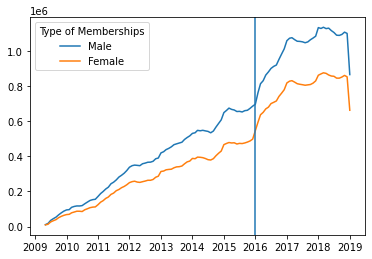

In [12]:
#Plot the chart of monthly revenue
date_min = pd.Timestamp('2009-05-01') 
date_max = pd.Timestamp('2019-01-01') 
Date = pd.date_range(date_min, date_max, freq = 'MS')
Male_data = pd.DataFrame(member_data.xs('Male', level=1, drop_level=False))
Female_data = pd.DataFrame(member_data.xs('Female', level=1, drop_level=False))
Male = Male_data['Total_Revenue']
Female = Female_data['Total_Revenue']
plt.plot(Date,Male,label='Male')
plt.plot(Date,Female,label='Female')
plt.legend(title='Type of Memberships')
plt.axvline(x='2016-01-01')

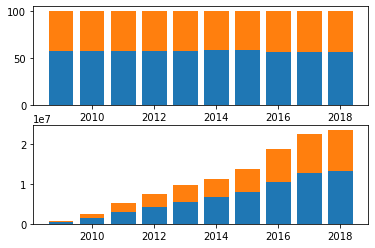

In [13]:
# Plot the Percent stacked barplot and barplot of yearly revenue,seperating the Gender
r =  np.arange(2009,2019)
Male_data = pd.DataFrame(member_data_yearly.xs('Male', level=1, drop_level=False)).drop([2019])
Female_data = pd.DataFrame(member_data_yearly.xs('Female', level=1, drop_level=False)).drop([2019])
Male_Revenue = Male_data['Total_Revenue']
Female_Revenue = Female_data['Total_Revenue']
totals = [i+j for i,j in zip(Male_Revenue, Female_Revenue)]
Male_revenue_stacked = [i / j * 100 for i,j in zip(Male_Revenue, totals)]
Female_revenue_stacked = [i / j * 100 for i,j in zip(Female_Revenue, totals)] 
plt.subplot(2, 1, 1)
plt.bar(r,Male_revenue_stacked)
plt.bar(r,Female_revenue_stacked, bottom=Male_revenue_stacked)
plt.subplot(2, 1, 2)
plt.bar(r,Male_Revenue)
plt.bar(r,Female_Revenue, bottom=Male_Revenue)
plt.show()

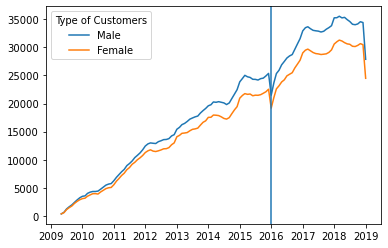

In [14]:
# Plot the cumulative members monthly
Dates = pd.date_range(min(Date), max(Date), freq = 'MS')
Male = member_data.xs('Male', level=1, drop_level=False)['Cumulative_Member']
Female = member_data.xs('Female', level=1, drop_level=False)['Cumulative_Member']
plt.plot(Dates,Male,label='Male')
plt.plot(Dates,Female,label='Female')
plt.legend(title='Type of Customers')
plt.axvline(x='2016-01-01')

In [15]:
# Draw the growth of new Female member and new Male member
Date = Cumulative_Members_seperating_revenue['Date']
Male = Cumulative_Members_seperating_revenue['New_Male_member']
Female = Cumulative_Members_seperating_revenue['New_Female_member']
plt.plot(Date,Male,label='Male')
plt.plot(Date,Female,label='Female')
plt.legend(title='Type of Memberships')
plt.axvline(x='2016-01-01')

NameError: name 'Cumulative_Members_seperating_revenue' is not defined